In [1]:
from fuzzyART_gai import *
from handytools import *
import sklearn.datasets as ds
import sklearn.decomposition as dcp
import matplotlib.pyplot as plt

In [2]:
iris = ds.load_iris()
data = iris['data'] / np.max(iris['data'], axis=0)
label_true = iris['target']
# pca
pca = dcp.PCA(n_components=2)
pca_xy = pca.fit_transform(data)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.92138578 0.05142129]
[4.9602239  1.17179601]


0.0
figure saved at _simcache/2022-03-18_17-43-08_var_rho0
0.1111111111111111
figure saved at _simcache/2022-03-18_17-43-08_var_rho11
0.2222222222222222
figure saved at _simcache/2022-03-18_17-43-09_var_rho22
0.3333333333333333
figure saved at _simcache/2022-03-18_17-43-10_var_rho33
0.4444444444444444
figure saved at _simcache/2022-03-18_17-43-11_var_rho44
0.5555555555555556
figure saved at _simcache/2022-03-18_17-43-11_var_rho55
0.6666666666666666
figure saved at _simcache/2022-03-18_17-43-12_var_rho66
0.7777777777777777
figure saved at _simcache/2022-03-18_17-43-13_var_rho77
0.8888888888888888
figure saved at _simcache/2022-03-18_17-43-14_var_rho88
1.0
figure saved at _simcache/2022-03-18_17-43-16_var_rho100


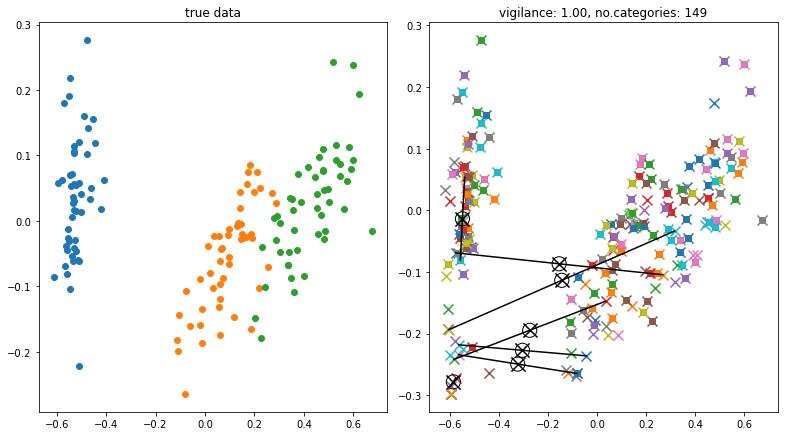

In [3]:
no_rho = 10
ls_rho = np.linspace(0, 1, no_rho)
fig, axs = plt.subplots(1, 2,
                        figsize = (11, 6))
fig.tight_layout()

# plot true
for cat_true in range(3):
    axs[0].scatter(*np.where(label_true == cat_true, pca_xy.T, None))
axs[0].set_title('true data')

ax = axs[1]
for rho in ls_rho: 
    print(rho)
    # init
    net = FuzzyARTgai(alpha=0.5, rho=rho)
    
    # train
    net.train(data, epochs=100) # each epoch, all data is shuffled
    label_pred = net.test(data).astype(int)

    # plot 
    cat_number = net.w.shape[0]
    cat_centre = pca.transform(net.w[:, :4])
    for cat_pred, cat_x, cat_y in zip(range(cat_number), *cat_centre.T):
        c = next(ax._get_lines.prop_cycler)['color']
        ax.scatter(*np.where(label_pred == cat_pred, pca_xy.T, None), color = c) # all training samples
        ax.scatter(cat_x, cat_y, marker = 'x', s = 100, color = c) # categorical centre
    ax.set_title('vigilance: {:.2f}, no.categories: {}'.format(rho, cat_number))
    
    if 1 < cat_number:
        # interplot 2 cats
        inter01 = pca.transform([np.mean(net.w[:2, :4], axis = 0)])
        ax.scatter(*inter01.T, marker = 'o', s = 200, edgecolors = 'k', facecolors='none')
        interpca01 = np.mean(cat_centre[:2], axis = 0)
        ax.scatter(*interpca01.T, marker = 'x', s = 200, c = 'k')
        ax.plot(*cat_centre[:2].T, c = 'k')
        
    # save fig
    simname = 'var_rho{:d}'.format(int(rho*100))
    dirname = '_simcache'
    savefigure_datetime(fig, simname, dirname)